In [4]:
!pip install -Uq gpytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 4.6 MB/s eta 0:00:00


In [5]:
import tqdm
import math
import torch
import numpy as np

import torch.distributions as dist

import gpytorch
import pandas as pd
from matplotlib import pyplot as plt

# Code

In [6]:
 import math
from numbers import Number, Real

import torch
from torch.distributions import constraints
from torch.distributions.exp_family import ExponentialFamily
from torch.distributions.utils import _standard_normal, broadcast_all

__all__ = ["CensoredNormal"]



class CensoredNormal(ExponentialFamily):
    """
    Creates a censored normal (also called Gaussian) distribution parameterized by
    :attr:`loc` and :attr:`scale` and :attr:`low`  and :attr:`high`

    Example::

        >>> # xdoctest: +IGNORE_WANT("non-deterministic")
        >>> m = CensoredNormal(
          torch.tensor([0.0]), torch.tensor([1.0]),
          torch.tensor([-0.5]), torch.tensor([0.5])
          )
        >>> m.sample(sample_shape=(3,1))
        tensor([[0.5000],
            [0.5000],
            [0.1836]])
        tensor([ 0.1046])

    Args:
        loc (float or Tensor): mean of the base normal distribution (often referred to as mu) to which the censoring is applied
        scale (float or Tensor): standard deviation of the base normal distribution to which the censoring is applied
        low (float or Tensor): lower censoring boundary
        high (float or Tensor): upper censoring boundary
    """
    arg_constraints = {
        "loc": constraints.real,
        "scale": constraints.positive,
        "low": constraints.dependent(is_discrete=False, event_dim=0),
        "high": constraints.dependent(is_discrete=False, event_dim=0)}
    has_rsample = True
    _mean_carrier_measure = 0

    @property
    def mean(self):
        x_high = (self.high - self.loc)/self.scale
        cdf_high = self._normal_cdf(self.high)
        pdf_high = math.exp(self._normal_log_prob(self.high))
        x_low = (self.low - self.loc)/self.scale
        cdf_low = self._normal_cdf(self.low)
        pdf_low = math.exp(self._normal_log_prob(self.low))
        term1 = cdf_high - cdf_low
        term2 = pdf_high - pdf_low
        return self.loc * term1 - self.scale * term2

    @property
    def stddev(self):
        return self.variance.sqrt()

    @property
    def variance(self):
        x_high = (self.high - self.loc)/self.scale
        cdf_high = self._normal_cdf(self.high)
        pdf_high = math.exp(self._normal_log_prob(self.high))
        x_low = (self.low - self.loc)/self.scale
        cdf_low = self._normal_cdf(self.low)
        pdf_low = math.exp(self._normal_log_prob(self.low))
        term1 = cdf_high - cdf_low
        term2 = x_high * pdf_high - x_low * pdf_low
        return  (self.scale ** 2) * (term1 - term2)


    def __init__(self, loc, scale, low, high, validate_args=None):
        self.loc, self.scale, self.low, self.high = broadcast_all(loc, scale, low, high)
        if isinstance(loc, Number) and isinstance(scale, Number) and isinstance(low, Number) and isinstance(high, Number):
            batch_shape = torch.Size()
        else:
            batch_shape = self.loc.size()
        support = constraints.interval(low, high)
        super().__init__(batch_shape, validate_args=validate_args)

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(CensoredNormal, _instance)
        batch_shape = torch.Size(batch_shape)
        new.loc = self.loc.expand(batch_shape)
        new.scale = self.scale.expand(batch_shape)
        new.low = self.low.expand(batch_shape)
        new.high = self.high.expand(batch_shape)
        super(CensoredNormal, new).__init__(batch_shape, validate_args=False)
        new._validate_args = self._validate_args
        return new

    @constraints.dependent_property(is_discrete=False, event_dim=0)
    def support(self):
        return constraints.interval(self.low, self.high)


    def sample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        with torch.no_grad():
            samples = torch.normal(self.loc.expand(shape), self.scale.expand(shape))
            return samples.clamp(min=self.low, max=self.high)


    def rsample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        eps = _standard_normal(shape, dtype=self.loc.dtype, device=self.loc.device)
        rsamples =  self.loc + eps * self.scale
        return rsamples.clamp(min=self.low, max=self.high)

    def pdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        probs = torch.exp(self.log_prob(value))
        lower_cdf_mass = self._normal_cdf(self.low)
        upper_cdf_mass = 1 - self._normal_cdf(self.high)
        probs = torch.where(value <= self.low, lower_cdf_mass, probs)
        probs = torch.where(value >= self.high, upper_cdf_mass, probs)
        return probs

    def log_prob(self, value, jitter=1e-12):
        """jitter: used to bounce off NormCDF from 0 before applying log """
        if self._validate_args:
            self._validate_sample(value)
        log_probs = self._normal_log_prob(value)
        lower_log_cdf_mass = math.log(self._normal_cdf(self.low) + jitter) if isinstance(self._normal_cdf(self.low) + jitter,
                                                                                                Number) else (self._normal_cdf(self.low) + jitter).log()
        upper_log_cdf_mass = math.log(1 - self._normal_cdf(self.high) + jitter) if isinstance(1 - self._normal_cdf(self.high) + jitter,
                                                                                                    Number) else (1 - self._normal_cdf(self.high) + jitter).log()
        log_probs = torch.where(value <= self.low, lower_log_cdf_mass, log_probs)
        log_probs = torch.where(value >= self.high, upper_log_cdf_mass, log_probs)
        return log_probs

    def cdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        cdf_ = self._normal_cdf(value)
        cdf_ = torch.where(value < self.low, 0, cdf_)
        cdf_ = torch.where(value > self.high, 1, cdf_)
        return cdf_

    def icdf(self, value):
        result = self._normal_icdf(value)
        return result.clamp(min=self.low, max=self.high)

    def entropy(self, jitter=1e-12):
        x_low = (self.low - self.loc)/self.scale
        x_high = (self.high - self.loc)/self.scale

        logcdf_x_low = math.log(self._normal_cdf(self.low) + jitter) if isinstance(self._normal_cdf(self.low) + jitter,
                                                                                                  Number) else (self._normal_cdf(self.low) + jitter).log()
        logcdf_x_high = math.log(self._normal_cdf_standardized(-x_high) + jitter) if isinstance(self._normal_cdf_standardized(x_high) + jitter,
                                                                                                      Number) else (self._normal_cdf_standardized(-x_high) + jitter).log()

        term1 = self._normal_entropy() * (self._normal_cdf(self.high)- self._normal_cdf(self.low))
        term2 = 0.5 * (x_high * torch.exp(self._normal_log_prob(self.high)) - x_low * torch.exp(self._normal_log_prob(self.low)))
        term3 = logcdf_x_low * self._normal_cdf(self.low)
        term4 = logcdf_x_high * (self._normal_cdf_standardized(-x_high))
        return term1 - term2 - term3 - term4


    def _normal_log_prob(self, value):
            # compute the variance
            var = self.scale**2
            log_scale = (
                math.log(self.scale) if isinstance(self.scale, Real) else self.scale.log()
            )
            return (
                -((value - self.loc) ** 2) / (2 * var)
                - log_scale
                - math.log(math.sqrt(2 * math.pi))
            )

    def _normal_cdf(self, value):
        return 0.5 * (
            1 + torch.erf((value - self.loc) * self.scale.reciprocal() / math.sqrt(2))
        )

    def _normal_cdf_standardized(self, z):
        return 0.5 * (
            1 + torch.erf(z / math.sqrt(2))
        )

    def _normal_icdf(self, value):
        return self.loc + self.scale * torch.erfinv(2 * value - 1) * math.sqrt(2)


    def _normal_entropy(self):\
        # log(sqrt(2 pi e) * sigma) = 0.5 * log(2 pi e) + log(sigma) = 0.5 + 0.5 (log(2 pi)) + log(sigma)
        return 0.5 + 0.5 * math.log(2 * math.pi) + torch.log(self.scale)

    @property
    def _normal_natural_params(self):
        return (self.loc / self.scale.pow(2), -0.5 * self.scale.pow(2).reciprocal())

    def _log_normalizer(self, x, y):
        return -0.25 * x.pow(2) / y + 0.5 * torch.log(-math.pi / y)

In [103]:
import math
import warnings
from copy import deepcopy
from typing import Any, Optional, Tuple, Union

import numpy as np
import torch
import torch.distributions as dist
from torch import Tensor
from gpytorch.likelihoods.likelihood import _Likelihood
from gpytorch.likelihoods.noise_models import HomoskedasticNoise


class CensoredGaussianLikelihood(_Likelihood):
    """Base class for Censored Gaussian Likelihoods."""
    def __init__(self, variance=None, low=None, high=None) -> None:
        super().__init__()

        variance = torch.tensor(1.) if variance is None else variance
        self.noise = HomoskedasticNoise()
        self.noise.initialize(noise=variance)
        self.low = low
        self.high = high

    @property
    def variance(self):
      return self.noise.noise

    def forward(self, function_samples: Tensor, *params: Any, **kwargs: Any):
        return CensoredNormal(function_samples, scale=self.variance.sqrt(), low=self.low, high=self.high)


class CensoredGaussianLikelihoodAnalytic(CensoredGaussianLikelihood):
    def __init__(self, variance=None, low=None, high=None, alpha=1., gamma=1., dzeta=1., jitter_=1e-16) -> None:
        super().__init__(variance, low, high)
        self.alpha = alpha
        self.gamma = gamma
        self.dzeta = dzeta
        self.jitter_ = jitter_

    def _expected_log_prob_terms(self, target: Tensor, input: dist.MultivariateNormal, *params: Any, **kwargs: Any) -> Tensor:

        noise = self.variance # likelihood
        sigma = noise.sqrt()
        mean, variance = input.mean, input.variance # approximate posterior
        std = variance.sqrt()

        upper_censor = lambda x, s: (self.high - x) / s
        lower_censor = lambda x, s: (self.low - x) / s

        standard_normal = dist.Normal(0,1)
         # Gaussian term
        res = ((target - mean).square() + variance) / noise + noise.log() + math.log(2 * math.pi)
        res = res.mul(-0.5)
        uncensored_cdf = standard_normal.cdf(upper_censor(mean, std)) - standard_normal.cdf(lower_censor(mean, std))
        normal_part = res * uncensored_cdf  # maximized

        # upper term
        x = 0.5 * (self.high - 2*target + mean) * std * noise.reciprocal()  # minimized
        upper_term_cdf = standard_normal.cdf(-upper_censor(target, sigma))
        ln_cdf = torch.clamp_min(upper_term_cdf, self.jitter_).log()
        upper_term_pdf = standard_normal.log_prob(upper_censor(mean, std)).exp()
        upper_censored_part = (ln_cdf + x) * upper_term_pdf  # minimized

        # lower term
        x = 0.5 * (self.low - 2*target + mean) * std * noise.reciprocal()  # maximized
        lower_term_cdf = standard_normal.cdf(lower_censor(target, sigma))
        ln_cdf = torch.clamp_min(lower_term_cdf, self.jitter_).log()
        lower_term_pdf = standard_normal.log_prob(lower_censor(mean, std)).exp()
        lower_censored_part = (ln_cdf - x) * lower_term_pdf  # minimized

        Phi = lambda m, s, a: torch.special.erf((a - m) / (np.sqrt(2) * s))

        return dict(normal_part=normal_part, normal_part_cdf=uncensored_cdf,
                    upper_censored_part=upper_censored_part, upper_term_pdf=upper_term_pdf,
                    lower_censored_part=lower_censored_part, lower_term_pdf=lower_term_pdf,
                    lower_cdf_pred=Phi(self.low, std, mean), upper_cdf_pred=Phi(self.high, std, mean),
                    lower_cdf_target=Phi(self.low, sigma, target), upper_cdf_target=Phi(self.high, sigma, target)
                    )

    def expected_log_prob(self, target: Tensor, input: dist.MultivariateNormal, *params: Any, **kwargs: Any) -> Tensor:
      terms = self._expected_log_prob_terms(target, input, *params, **kwargs)
      return self.alpha * terms['normal_part'] + self.gamma * terms['upper_censored_part'] + self.dzeta * terms['lower_censored_part']


class CensoredGaussianLikelihoodMathematica(CensoredGaussianLikelihood):
    # Dani's original implementation
    def __init__(self, variance=None, low=None, high=None) -> None:
        super().__init__(variance, low, high)

    def expected_log_prob(self, target: Tensor, input: dist.MultivariateNormal, *params: Any, **kwargs: Any) -> Tensor:
        noise = self.variance # likelihood
        mean, variance = input.mean, input.variance # approximate posterior

        jitter_=1e-16

        upper_censor = lambda x, s: (self.high - x) / s
        lower_censor = lambda x, s: (self.low - x) / s

        standard_normal = dist.Normal(0,1)
         # Gaussian term
        term1 = 2. + torch.log(noise) + math.log(2 * math.pi)
        term2 = ((target - mean).square() + variance) * noise.reciprocal()
        term3 = standard_normal.cdf(upper_censor(mean, variance.sqrt())) - standard_normal.cdf(lower_censor(mean, variance.sqrt()))
        normal_part_unscaled = (term1 - term2).mul(0.5)
        normal_part = normal_part_unscaled * term3

        # upper term
        x1 = (self.high - 2*target + mean) * variance.sqrt()
        term4 = torch.clamp_min(standard_normal.cdf(-upper_censor(target, variance.sqrt())), jitter_).log() + 0.5 * x1 * noise.reciprocal()
        upper_censored_part = term4 * standard_normal.log_prob(upper_censor(mean, variance.sqrt())).exp()

        # lower term
        x2 = (self.low - 2*target + mean) * variance.sqrt()
        term5 = torch.clamp_min(standard_normal.cdf(lower_censor(target, variance.sqrt())), jitter_).log() - 0.5 * x2 * noise.reciprocal()
        lower_censored_part = term5 * standard_normal.log_prob(lower_censor(mean, variance.sqrt())).exp()

        res = normal_part - lower_censored_part - upper_censored_part
        return res


class CensoredGaussianLikelihoodMathematica(CensoredGaussianLikelihoodAnalytic):
    # Updated implementation -- overwrites previous
    def expected_log_prob(self, target: Tensor, input: dist.MultivariateNormal, *params: Any, **kwargs: Any) -> Tensor:
        noise = self.variance  # likelihood
        sigma = torch.sqrt(noise)
        sigma2 = noise

        mean, variance = input.mean, input.variance  # approximate posterior
        m = mean
        s = variance

        mu = target
        l = self.low
        u = self.high

        log = lambda x: torch.log(torch.maximum(x,torch.as_tensor(1e-8).to(x)))
        phi = lambda m, s, u: torch.exp(-((m - u) ** 2 / (2 * s ** 2)))
        Phi = lambda m, s, a: torch.special.erf((a - m) / (np.sqrt(2) * s))

        sqrt2pi = np.sqrt(2 * np.pi)
        log2 = np.log(2)
        logpi = np.log(np.pi)

        return (
                (log((1 / 2) * (1 - Phi(l, sigma, mu))) * phi(l, s, m)) / (sqrt2pi * s) +
                (log(1 + (1 / 2) * (-1 + Phi(u, sigma, mu))) * phi(u, s, m)) / (sqrt2pi * s) +
                (1 / (4 * sqrt2pi * sigma2)) * (
                        -2 * s * (l + m - 2 * mu) * phi(l, s, m) +
                        2 * s * (m + u - 2 * mu) * phi(m, s, u) -
                        sqrt2pi * Phi(m, s, l) * (
                                l ** 2 - m ** 2 - s ** 2 - 2 * l * mu + 2 * m * mu - sigma2 * log2 - sigma2 * logpi +
                                2 * sigma2 * log(phi(l, sigma, mu) / sigma)
                        ) +
                        sqrt2pi * Phi(u, s, m) * (
                                m ** 2 + s ** 2 - u ** 2 - 2 * m * mu + 2 * u * mu + sigma2 * log2 + sigma2 * logpi -
                                2 * sigma2 * log(phi(u, sigma, mu) / sigma)
                        )
                )
        )

In [104]:
def rgetattr(o, k_list):
  for k in k_list:
    o = getattr(o,k)
  return o

def print_module(module):
  with torch.no_grad():
    for name, _ in module.named_parameters():
      name = name.replace('raw_','')
      param = rgetattr(module, name.split('.'))
      print(f'{name:35} {tuple(param.shape)}\n{param.numpy().round(10)}')

def get_module(module):
  ret = {}
  with torch.no_grad():
    for name, _ in module.named_parameters():
      name = name.replace('raw_','')
      param = rgetattr(module, name.split('.'))
      ret[name] = param.numpy()
  return ret

In [105]:
def branin_hoo(x):
    """
    Branin-Hoo test function (2d)
    http://www.sfu.ca/~ssurjano/branin.html
    """
    x1 = x[:,0]
    x2 = x[:,1]
    try:
        x1 = x1.numpy()
        x2 = x2.numpy()
    except:
        pass
    x1 = 15 * x1 - 5
    x2 = 15 * x2
    b = 5.1 / (4 * np.pi**2)
    c = 5.0 / np.pi
    r = 6
    s = 10
    t = 1/(8 * np.pi)
    v = (x2 - b*x1**2 + c*x1 - r)**2 + s * (1 - t) * np.cos(x1) + s
    if isinstance(x, torch.Tensor):
        return torch.FloatTensor(v)
    else:
        return v

In [106]:
MAX_VALUE= 50.0

def oracle(x, output_noise=0.0):
    r = branin_hoo(x)
#     r = r + torch.randn(r.shape)*output_noise
    r[r > MAX_VALUE] = MAX_VALUE
    return r

def oracle_binarized(x):
    r = oracle(x)
    fail = r >= MAX_VALUE
    r[fail] = 0
    r[~fail] = 1
    return r

def plot_test_function(fn):
    domain = torch.linspace(0, 1, 100)
    xx, yy = torch.meshgrid(domain, domain)
    xxyy = torch.stack((xx.ravel(), yy.ravel())).T
    zz = fn(xxyy).reshape(xx.shape)
    if zz.max() == 1.0:
        plt.contourf(xx, yy, zz)
    else:
        plt.contourf(xx, yy, zz) # , levels=2**np.arange(0, int(np.ceil(np.log2(zz.max()))), 0.5)-1)
    plt.colorbar()

# Synthetic 2D

In [107]:
MAX_VALUE= 50.0

N_init = 10
np.random.seed(4)
x = torch.FloatTensor(np.random.rand(N_init, 2))
y = oracle(x)

# test data
domain = torch.linspace(0, 1, 100)
xx, yy = torch.meshgrid(domain, domain)
xxyy = torch.stack((xx.ravel(), yy.ravel())).T
y_test = branin_hoo(xxyy)
y_test_censored = oracle(xxyy)

# MC Simulation

In [108]:
from gpytorch.models import ApproximateGP # handles basic variational inference
from gpytorch.variational import CholeskyVariationalDistribution # distribution of the approximation q(f)
from gpytorch.variational import VariationalStrategy # use when larger sample - transform q(u) to q(f) over inducing points

class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        # defines approximation
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points,
                                                   variational_distribution, learn_inducing_locations=False)
        super(GPModel, self).__init__(variational_strategy)
        # defines the GP
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

model = GPModel(inducing_points=x[:,:])

# ELBO Likelihood
likelihood = CensoredGaussianLikelihoodAnalytic(low=-1000., high=MAX_VALUE)

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

In [109]:
num_epochs = 30_000
pbar = tqdm.tqdm(range(num_epochs), position=0, leave=True)

model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.001)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, beta=1., combine_terms=False, num_data=y.size(0))

params_log = dict()
metrics = dict()
for iter in pbar:
    optimizer.zero_grad()
    y_pred = model(x)
    log_likelihood, kl_divergence, log_prior  = mll(y_pred, y)
    loss = -(log_likelihood - kl_divergence + log_prior)
    loss.backward()
    optimizer.step()
    params_log[iter] = {
        'loss': loss.item(),
        'log_likelihood': log_likelihood.item(),
        'kl_divergence': kl_divergence.item(),
        'log_prior': log_prior.item(),
        'outscale': model.covar_module.outputscale.item(),
        'mean_module': model.mean_module.constant.item(),
        'noise': likelihood.noise.noise.item()
        }

    if iter%500==0:
      for key, val in params_log[iter].items():
        print(key, val)

      model.eval()
      likelihood.eval()
      metrics[iter] = {
        'mae': gpytorch.metrics.mean_absolute_error(model(xxyy), y_test).numpy(force=True),
        'posterior_log_prob': model(xxyy).log_prob(y_test).mean().numpy(force=True),
        'npld_posterior': gpytorch.metrics.negative_log_predictive_density(model(xxyy), y_test).mean().numpy(force=True),
        'npld_predictive_posterior': gpytorch.metrics.negative_log_predictive_density(likelihood(model(xxyy)), y_test_censored).mean().numpy(force=True)
      }
      model.train()

  0%|          | 0/30000 [00:00<?, ?it/s]

loss 495.2884826660156
log_likelihood -495.2884826660156
kl_divergence 4.76837158203125e-07
log_prior 0.0
outscale 0.6926472783088684
mean_module 0.0009999999310821295
noise 1.0006321668624878


  2%|▏         | 500/30000 [00:19<05:44, 85.67it/s]

loss 355.2098693847656
log_likelihood -354.97918701171875
kl_divergence 0.23068752884864807
log_prior 0.0
outscale 1.120112419128418
mean_module 0.46647778153419495
noise 1.3075947761535645


  3%|▎         | 994/30000 [00:50<05:14, 92.29it/s]

loss 269.32098388671875
log_likelihood -268.5758056640625
kl_divergence 0.7451812028884888
log_prior 0.0
outscale 1.6693408489227295
mean_module 0.8788995146751404
noise 1.5901367664337158


  3%|▎         | 994/30000 [01:06<05:14, 92.29it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.479015350341797 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.7977821826934814 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
  5%|▍         | 1494/30000 [01:52<05:10, 91.80it/s]

loss 212.12811279296875
log_likelihood -210.75552368164062
kl_divergence 1.372584581375122
log_prior 0.0
outscale 2.214663505554199
mean_module 1.2585794925689697
noise 1.8516285419464111


  5%|▍         | 1494/30000 [02:06<05:10, 91.80it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.4553475379943848 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.034780740737915 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
  7%|▋         | 1998/30000 [02:53<05:09, 90.44it/s]

loss 170.89486694335938
log_likelihood -168.8248748779297
kl_divergence 2.0699925422668457
log_prior 0.0
outscale 2.73956561088562
mean_module 1.61698579788208
noise 2.096001625061035


  7%|▋         | 1998/30000 [03:06<05:09, 90.44it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.7329063415527344 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.58779239654541 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
  8%|▊         | 2500/30000 [03:56<04:59, 91.92it/s]

loss 139.7557373046875
log_likelihood -136.9467010498047
kl_divergence 2.8090434074401855
log_prior 0.0
outscale 3.2413058280944824
mean_module 1.9610589742660522
noise 2.3264660835266113


  8%|▊         | 2500/30000 [04:16<04:59, 91.92it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 5.652374744415283 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 6.651199817657471 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 10%|█         | 3000/30000 [04:58<05:09, 87.27it/s]

loss 115.53007507324219
log_likelihood -111.94937896728516
kl_divergence 3.580692768096924
log_prior 0.0
outscale 3.721242666244507
mean_module 2.2952582836151123
noise 2.545586585998535


 10%|█         | 3000/30000 [05:16<05:09, 87.27it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 6.764892101287842 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 5.524168014526367 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 12%|█▏        | 3500/30000 [05:59<04:45, 92.66it/s]

loss 96.30335998535156
log_likelihood -91.93262481689453
kl_divergence 4.370737552642822
log_prior 0.0
outscale 4.1819562911987305
mean_module 2.6224825382232666
noise 2.7553393840789795


 12%|█▏        | 3500/30000 [06:16<04:45, 92.66it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 6.8712158203125 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 8.882365226745605 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 13%|█▎        | 3993/30000 [07:01<04:44, 91.55it/s]

loss 80.84033203125
log_likelihood -75.66702270507812
kl_divergence 5.173305988311768
log_prior 0.0
outscale 4.626145839691162
mean_module 2.944636821746826
noise 2.957183599472046


 13%|█▎        | 3993/30000 [07:16<04:44, 91.55it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 11.376376152038574 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 6.577270030975342 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 15%|█▍        | 4496/30000 [08:03<04:44, 89.67it/s]

loss 68.3254165649414
log_likelihood -62.326820373535156
kl_divergence 5.998593330383301
log_prior 0.0
outscale 5.056063175201416
mean_module 3.2628300189971924
noise 3.152161121368408


 15%|█▍        | 4496/30000 [08:16<04:44, 89.67it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 8.986989974975586 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 13.088601112365723 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 17%|█▋        | 4996/30000 [09:04<04:21, 95.56it/s]

loss 58.19777297973633
log_likelihood -51.34624481201172
kl_divergence 6.851529121398926
log_prior 0.0
outscale 5.473317623138428
mean_module 3.5775067806243896
noise 3.3410215377807617


 17%|█▋        | 4996/30000 [09:16<04:21, 95.56it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 10.309233665466309 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 13.031205177307129 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 18%|█▊        | 5493/30000 [10:06<04:30, 90.56it/s]

loss 50.0330696105957
log_likelihood -42.31494140625
kl_divergence 7.7181267738342285
log_prior 0.0
outscale 5.879072666168213
mean_module 3.888768434524536
noise 3.5243797302246094


 18%|█▊        | 5493/30000 [10:16<04:30, 90.56it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 15.630684852600098 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 10.95346450805664 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 20%|█▉        | 5991/30000 [11:08<04:13, 94.87it/s]

loss 43.47770690917969
log_likelihood -34.9108772277832
kl_divergence 8.566829681396484
log_prior 0.0
outscale 6.27439022064209
mean_module 4.196768283843994
noise 3.702810287475586


 20%|█▉        | 5991/30000 [11:26<04:13, 94.87it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 16.34919548034668 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 17.093204498291016 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 22%|██▏       | 6495/30000 [12:10<04:09, 94.35it/s]

loss 38.22227478027344
log_likelihood -28.864700317382812
kl_divergence 9.357576370239258
log_prior 0.0
outscale 6.660493850708008
mean_module 4.502060413360596
noise 3.8769032955169678


 22%|██▏       | 6495/30000 [12:26<04:09, 94.35it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 11.904690742492676 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 9.374638557434082 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 23%|██▎       | 6991/30000 [13:13<03:57, 97.07it/s]

loss 33.998687744140625
log_likelihood -23.942996978759766
kl_divergence 10.055692672729492
log_prior 0.0
outscale 7.038869857788086
mean_module 4.805819034576416
noise 4.04726505279541


 23%|██▎       | 6991/30000 [13:26<03:57, 97.07it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 8.1747407913208 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 9.456974029541016 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 25%|██▍       | 7498/30000 [14:17<03:55, 95.53it/s]

loss 30.587238311767578
log_likelihood -19.94474220275879
kl_divergence 10.642497062683105
log_prior 0.0
outscale 7.41115665435791
mean_module 5.109857559204102
noise 4.214498996734619


 25%|██▍       | 7498/30000 [14:36<03:55, 95.53it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 16.35198211669922 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 8.268156051635742 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 27%|██▋       | 7991/30000 [15:21<03:54, 93.89it/s]

loss 27.81796646118164
log_likelihood -16.706510543823242
kl_divergence 11.111454963684082
log_prior 0.0
outscale 7.778878211975098
mean_module 5.416228294372559
noise 4.379210472106934


 27%|██▋       | 7991/30000 [15:36<03:54, 93.89it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 19.1645450592041 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 8.478653907775879 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 28%|██▊       | 8495/30000 [16:25<03:53, 92.14it/s]

loss 25.562686920166016
log_likelihood -14.102925300598145
kl_divergence 11.459760665893555
log_prior 0.0
outscale 8.143203735351562
mean_module 5.726869583129883
noise 4.542123317718506


 28%|██▊       | 8495/30000 [16:36<03:53, 92.14it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 12.675278663635254 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 13.51021957397461 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 30%|███       | 9000/30000 [17:30<03:47, 92.32it/s]

loss 23.72470474243164
log_likelihood -12.037904739379883
kl_divergence 11.686799049377441
log_prior 0.0
outscale 8.504897117614746
mean_module 6.043315887451172
noise 4.7042975425720215


 30%|███       | 9000/30000 [17:46<03:47, 92.32it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 28.768531799316406 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 22.479734420776367 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 32%|███▏      | 9495/30000 [18:34<03:55, 86.91it/s]

loss 22.225811004638672
log_likelihood -10.434297561645508
kl_divergence 11.791512489318848
log_prior 0.0
outscale 8.864391326904297
mean_module 6.36659574508667
noise 4.867325305938721


 32%|███▏      | 9495/30000 [18:46<03:55, 86.91it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 25.97895622253418 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 21.697744369506836 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 33%|███▎      | 9994/30000 [19:41<03:56, 84.66it/s]

loss 20.993484497070312
log_likelihood -9.225473403930664
kl_divergence 11.768010139465332
log_prior 0.0
outscale 9.222077369689941
mean_module 6.697333335876465
noise 5.033675670623779


 33%|███▎      | 9994/30000 [19:56<03:56, 84.66it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 28.334814071655273 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 13.363415718078613 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 35%|███▍      | 10492/30000 [20:46<03:28, 93.56it/s]

loss 19.95659637451172
log_likelihood -8.350686073303223
kl_divergence 11.605911254882812
log_prior 0.0
outscale 9.578584671020508
mean_module 7.0360870361328125
noise 5.206833839416504


 35%|███▍      | 10492/30000 [20:56<03:28, 93.56it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 22.982879638671875 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 27.327112197875977 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 37%|███▋      | 10993/30000 [21:50<03:19, 95.50it/s]

loss 19.04916763305664
log_likelihood -7.750594139099121
kl_divergence 11.29857349395752
log_prior 0.0
outscale 9.935323715209961
mean_module 7.3838629722595215
noise 5.391391754150391


 37%|███▋      | 10993/30000 [22:06<03:19, 95.50it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 23.6162166595459 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 16.122329711914062 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 38%|███▊      | 11494/30000 [22:53<03:15, 94.77it/s]

loss 18.21904754638672
log_likelihood -7.362274169921875
kl_divergence 10.856772422790527
log_prior 0.0
outscale 10.294170379638672
mean_module 7.742394924163818
noise 5.592741012573242


 38%|███▊      | 11494/30000 [23:06<03:15, 94.77it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 14.544586181640625 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 16.011051177978516 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 40%|███▉      | 11992/30000 [23:57<03:16, 91.87it/s]

loss 17.432979583740234
log_likelihood -7.11818790435791
kl_divergence 10.31479263305664
log_prior 0.0
outscale 10.657116889953613
mean_module 8.113753318786621
noise 5.816152095794678


 40%|███▉      | 11992/30000 [24:16<03:16, 91.87it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 18.323402404785156 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 23.429790496826172 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 42%|████▏     | 12498/30000 [25:01<03:37, 80.63it/s]

loss 16.675033569335938
log_likelihood -6.954218864440918
kl_divergence 9.72081470489502
log_prior 0.0
outscale 11.025672912597656
mean_module 8.499491691589355
noise 6.065383434295654


 42%|████▏     | 12498/30000 [25:16<03:37, 80.63it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 15.310576438903809 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 17.913536071777344 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 43%|████▎     | 12992/30000 [26:04<03:06, 90.97it/s]

loss 15.941485404968262
log_likelihood -6.8213958740234375
kl_divergence 9.120089530944824
log_prior 0.0
outscale 11.400519371032715
mean_module 8.899890899658203
noise 6.341561794281006


 43%|████▎     | 12992/30000 [26:16<03:06, 90.97it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 25.98492431640625 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 12.098082542419434 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 45%|████▍     | 13495/30000 [27:09<03:00, 91.63it/s]

loss 15.235249519348145
log_likelihood -6.692150115966797
kl_divergence 8.543099403381348
log_prior 0.0
outscale 11.781478881835938
mean_module 9.313738822937012
noise 6.643065452575684


 45%|████▍     | 13495/30000 [27:26<03:00, 91.63it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 25.04773712158203 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 32.57183837890625 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 47%|████▋     | 13996/30000 [28:18<03:02, 87.93it/s]

loss 14.561296463012695
log_likelihood -6.557287693023682
kl_divergence 8.004009246826172
log_prior 0.0
outscale 12.167804718017578
mean_module 9.738718032836914
noise 6.96643590927124


 47%|████▋     | 13996/30000 [28:36<03:02, 87.93it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 14.54561996459961 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 10.71345329284668 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 48%|████▊     | 14493/30000 [29:27<03:09, 81.79it/s]

loss 13.923812866210938
log_likelihood -6.4176025390625
kl_divergence 7.5062103271484375
log_prior 0.0
outscale 12.55851936340332
mean_module 10.172076225280762
noise 7.307635307312012


 48%|████▊     | 14493/30000 [29:46<03:09, 81.79it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 23.088685989379883 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 10.89391040802002 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 50%|████▉     | 14997/30000 [30:34<02:48, 88.93it/s]

loss 13.325050354003906
log_likelihood -6.276707649230957
kl_divergence 7.048342704772949
log_prior 0.0
outscale 12.952702522277832
mean_module 10.61122989654541
noise 7.662932395935059


 50%|████▉     | 14997/30000 [30:46<02:48, 88.93it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 42.00979995727539 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 32.8484992980957 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 52%|█████▏    | 15494/30000 [31:39<02:46, 87.36it/s]

loss 12.765380859375
log_likelihood -6.137753009796143
kl_divergence 6.627627372741699
log_prior 0.0
outscale 13.349608421325684
mean_module 11.054056167602539
noise 8.029261589050293


 52%|█████▏    | 15494/30000 [31:56<02:46, 87.36it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 22.907142639160156 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 32.17576217651367 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 53%|█████▎    | 15993/30000 [32:50<03:03, 76.42it/s]

loss 12.243799209594727
log_likelihood -6.002723217010498
kl_divergence 6.241076469421387
log_prior 0.0
outscale 13.748697280883789
mean_module 11.498937606811523
noise 8.404253005981445


 53%|█████▎    | 15993/30000 [33:06<03:03, 76.42it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 22.834794998168945 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 23.24073600769043 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 55%|█████▍    | 16495/30000 [34:04<02:43, 82.73it/s]

loss 11.758481979370117
log_likelihood -5.872720241546631
kl_divergence 5.8857622146606445
log_prior 0.0
outscale 14.149603843688965
mean_module 11.944719314575195
noise 8.786128044128418


 55%|█████▍    | 16495/30000 [34:16<02:43, 82.73it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 36.31821060180664 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 30.051740646362305 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 57%|█████▋    | 16994/30000 [35:11<02:25, 89.43it/s]

loss 11.30717658996582
log_likelihood -5.748297214508057
kl_divergence 5.558879375457764
log_prior 0.0
outscale 14.552164077758789
mean_module 12.390562057495117
noise 9.173567771911621


 57%|█████▋    | 16994/30000 [35:26<02:25, 89.43it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 12.270648956298828 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 21.821666717529297 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 58%|█████▊    | 17494/30000 [36:18<02:24, 86.76it/s]

loss 10.887422561645508
log_likelihood -5.629683971405029
kl_divergence 5.2577385902404785
log_prior 0.0
outscale 14.956233978271484
mean_module 12.836202621459961
noise 9.565600395202637


 58%|█████▊    | 17494/30000 [36:36<02:24, 86.76it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 30.962244033813477 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 37.88021469116211 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 60%|█████▉    | 17998/30000 [37:23<02:18, 86.49it/s]

loss 10.496879577636719
log_likelihood -5.516964912414551
kl_divergence 4.97991418838501
log_prior 0.0
outscale 15.361783981323242
mean_module 13.281241416931152
noise 9.961536407470703


 60%|█████▉    | 17998/30000 [37:36<02:18, 86.49it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 43.87123107910156 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 28.206892013549805 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 62%|██████▏   | 18492/30000 [38:29<02:03, 92.99it/s]

loss 10.133323669433594
log_likelihood -5.410126209259033
kl_divergence 4.7231974601745605
log_prior 0.0
outscale 15.768815994262695
mean_module 13.725435256958008
noise 10.360840797424316


 62%|██████▏   | 18492/30000 [38:46<02:03, 92.99it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 16.0678653717041 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 22.3820743560791 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 63%|██████▎   | 19000/30000 [39:34<01:56, 94.02it/s]

loss 9.794628143310547
log_likelihood -5.309016227722168
kl_divergence 4.485612392425537
log_prior 0.0
outscale 16.17741584777832
mean_module 14.168729782104492
noise 10.76314640045166


 63%|██████▎   | 19000/30000 [39:46<01:56, 94.02it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 48.335205078125 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 37.45354080200195 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 65%|██████▍   | 19498/30000 [40:39<02:30, 69.89it/s]

loss 9.478915214538574
log_likelihood -5.213527679443359
kl_divergence 4.265387535095215
log_prior 0.0
outscale 16.587472915649414
mean_module 14.611050605773926
noise 11.168180465698242


 65%|██████▍   | 19498/30000 [40:56<02:30, 69.89it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 37.44291687011719 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 28.58025550842285 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 67%|██████▋   | 19992/30000 [41:43<01:47, 93.41it/s]

loss 9.184440612792969
log_likelihood -5.1234564781188965
kl_divergence 4.060984134674072
log_prior 0.0
outscale 16.99904441833496
mean_module 15.052290916442871
noise 11.57572078704834


 67%|██████▋   | 19992/30000 [41:56<01:47, 93.41it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 58.2259635925293 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 60.997657775878906 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 68%|██████▊   | 20498/30000 [42:47<01:42, 93.00it/s]

loss 8.909587860107422
log_likelihood -5.0385637283325195
kl_divergence 3.8710238933563232
log_prior 0.0
outscale 17.412275314331055
mean_module 15.492431640625
noise 11.985617637634277


 68%|██████▊   | 20498/30000 [43:06<01:42, 93.00it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 34.98460388183594 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 27.516080856323242 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 70%|██████▉   | 20991/30000 [43:52<01:38, 91.56it/s]

loss 8.652961730957031
log_likelihood -4.958648681640625
kl_divergence 3.694312572479248
log_prior 0.0
outscale 17.827022552490234
mean_module 15.93138599395752
noise 12.397727966308594


 70%|██████▉   | 20991/30000 [44:06<01:38, 91.56it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 44.21929931640625 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 80.34839630126953 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 72%|███████▏  | 21495/30000 [44:57<01:32, 91.53it/s]

loss 8.413257598876953
log_likelihood -4.883490562438965
kl_divergence 3.5297675132751465
log_prior 0.0
outscale 18.243350982666016
mean_module 16.3690128326416
noise 12.811990737915039


 72%|███████▏  | 21495/30000 [45:16<01:32, 91.53it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 30.452613830566406 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 46.9329719543457 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 73%|███████▎  | 21996/30000 [46:03<01:34, 84.44it/s]

loss 8.18927001953125
log_likelihood -4.812841415405273
kl_divergence 3.3764281272888184
log_prior 0.0
outscale 18.66136360168457
mean_module 16.8053035736084
noise 13.228288650512695


 73%|███████▎  | 21996/30000 [46:16<01:34, 84.44it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 50.55058288574219 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 41.477272033691406 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 75%|███████▍  | 22491/30000 [47:08<01:22, 91.24it/s]

loss 7.979962348937988
log_likelihood -4.746513843536377
kl_divergence 3.2334487438201904
log_prior 0.0
outscale 19.0809268951416
mean_module 17.24004364013672
noise 13.646563529968262


 75%|███████▍  | 22491/30000 [47:26<01:22, 91.24it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 29.25922203063965 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 33.67450714111328 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 77%|███████▋  | 23000/30000 [48:16<01:22, 84.55it/s]

loss 7.784343242645264
log_likelihood -4.684260368347168
kl_divergence 3.1000828742980957
log_prior 0.0
outscale 19.50205421447754
mean_module 17.673154830932617
noise 14.066764831542969


 77%|███████▋  | 23000/30000 [48:26<01:22, 84.55it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 51.571495056152344 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 72.2003402709961 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 78%|███████▊  | 23500/30000 [49:23<01:27, 73.88it/s]

loss 7.601503849029541
log_likelihood -4.625885486602783
kl_divergence 2.975618362426758
log_prior 0.0
outscale 19.924915313720703
mean_module 18.104413986206055
noise 14.48884391784668


 78%|███████▊  | 23500/30000 [49:36<01:27, 73.88it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 37.555538177490234 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 43.728641510009766 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 80%|███████▉  | 23995/30000 [50:28<01:04, 92.77it/s]

loss 7.430647850036621
log_likelihood -4.571205139160156
kl_divergence 2.8594424724578857
log_prior 0.0
outscale 20.349348068237305
mean_module 18.53363609313965
noise 14.912752151489258


 80%|███████▉  | 23995/30000 [50:46<01:04, 92.77it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 55.967708587646484 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 52.75840759277344 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 82%|████████▏ | 24498/30000 [51:33<00:56, 97.26it/s]

loss 7.271014213562012
log_likelihood -4.520028591156006
kl_divergence 2.750985622406006
log_prior 0.0
outscale 20.775365829467773
mean_module 18.960630416870117
noise 15.33845043182373


 82%|████████▏ | 24498/30000 [51:46<00:56, 97.26it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 58.231483459472656 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 58.37222671508789 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 83%|████████▎ | 24991/30000 [52:38<00:54, 91.54it/s]

loss 7.121906280517578
log_likelihood -4.472170829772949
kl_divergence 2.649735689163208
log_prior 0.0
outscale 21.20307159423828
mean_module 19.38505744934082
noise 15.765924453735352


 83%|████████▎ | 24991/30000 [52:56<00:54, 91.54it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 65.00049591064453 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 50.82529067993164 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 85%|████████▍ | 25491/30000 [53:42<00:48, 92.29it/s]

loss 6.982677459716797
log_likelihood -4.42747163772583
kl_divergence 2.555206060409546
log_prior 0.0
outscale 21.6324405670166
mean_module 19.806684494018555
noise 16.195140838623047


 85%|████████▍ | 25491/30000 [53:56<00:48, 92.29it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 73.84143829345703 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 66.73332977294922 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 87%|████████▋ | 26000/30000 [54:47<00:48, 83.30it/s]

loss 6.852750301361084
log_likelihood -4.385764122009277
kl_divergence 2.4669861793518066
log_prior 0.0
outscale 22.063426971435547
mean_module 20.2250919342041
noise 16.626052856445312


 87%|████████▋ | 26000/30000 [55:06<00:48, 83.30it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 34.07482147216797 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 24.641263961791992 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 88%|████████▊ | 26492/30000 [55:51<00:37, 92.98it/s]

loss 6.731554985046387
log_likelihood -4.346900463104248
kl_divergence 2.3846545219421387
log_prior 0.0
outscale 22.496049880981445
mean_module 20.639965057373047
noise 17.058629989624023


 88%|████████▊ | 26492/30000 [56:06<00:37, 92.98it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 100.54495239257812 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 97.5426025390625 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 90%|████████▉ | 26995/30000 [56:56<00:33, 89.67it/s]

loss 6.618560791015625
log_likelihood -4.31074857711792
kl_divergence 2.307812452316284
log_prior 0.0
outscale 22.930418014526367
mean_module 21.05082893371582
noise 17.49297332763672


 90%|████████▉ | 26995/30000 [57:06<00:33, 89.67it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 57.35234069824219 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 32.75473403930664 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 92%|█████████▏| 27491/30000 [58:00<00:27, 91.89it/s]

loss 6.513301849365234
log_likelihood -4.277150630950928
kl_divergence 2.2361509799957275
log_prior 0.0
outscale 23.366479873657227
mean_module 21.45707893371582
noise 17.92896270751953


 92%|█████████▏| 27491/30000 [58:16<00:27, 91.89it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 66.07554626464844 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 75.17011260986328 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 93%|█████████▎| 27992/30000 [59:05<00:21, 92.62it/s]

loss 6.415316581726074
log_likelihood -4.245999336242676
kl_divergence 2.1693172454833984
log_prior 0.0
outscale 23.804216384887695
mean_module 21.858125686645508
noise 18.366567611694336


 93%|█████████▎| 27992/30000 [59:16<00:21, 92.62it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 54.37773132324219 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 98.26069641113281 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 95%|█████████▍| 28494/30000 [1:00:11<00:16, 89.68it/s]

loss 6.3241729736328125
log_likelihood -4.217173099517822
kl_divergence 2.106999635696411
log_prior 0.0
outscale 24.243640899658203
mean_module 22.25318145751953
noise 18.80579376220703


 95%|█████████▍| 28494/30000 [1:00:26<00:16, 89.68it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 48.07136154174805 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 44.25457000732422 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 97%|█████████▋| 28994/30000 [1:01:16<00:10, 92.83it/

loss 6.239444732666016
log_likelihood -4.190556526184082
kl_divergence 2.0488884449005127
log_prior 0.0
outscale 24.684764862060547
mean_module 22.641372680664062
noise 19.246749877929688


 97%|█████████▋| 28994/30000 [1:01:26<00:10, 92.83it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 62.68220138549805 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 69.87661743164062 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
 98%|█████████▊| 29497/30000 [1:02:21<00:05, 89.24it/

loss 6.160739898681641
log_likelihood -4.166031360626221
kl_divergence 1.9947086572647095
log_prior 0.0
outscale 25.127687454223633
mean_module 23.0216007232666
noise 19.689287185668945


 98%|█████████▊| 29497/30000 [1:02:36<00:05, 89.24it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 47.5715217590332 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 63.266929626464844 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
100%|██████████| 30000/30000 [1:03:26<00:00,  7.88it/

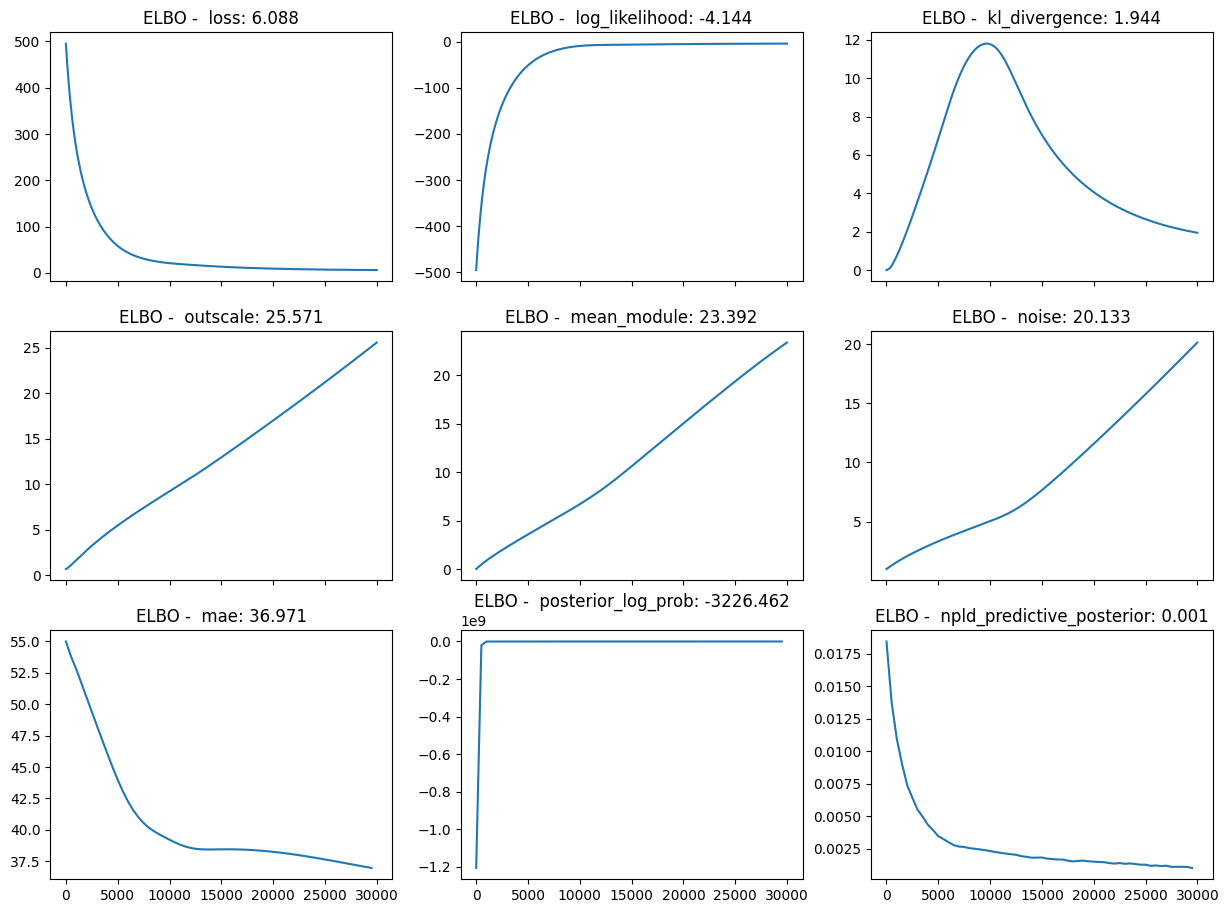

In [112]:
method = 'ELBO'
params_mc_benchmark = pd.DataFrame(params_log).T
metrics_mc_benchmark = pd.DataFrame(metrics).T
mc_benchmark_eval = pd.concat([params_mc_benchmark, metrics_mc_benchmark], axis=1)
cols = mc_benchmark_eval.columns.to_list()
cols.remove('log_prior')
cols.remove('npld_posterior')

fig, ax = plt.subplots(3,3, figsize=(15,11), sharex=True)
for col_, ax_ in zip(cols, ax.flatten()):
  mc_benchmark_eval[col_].dropna().astype('float').plot(title='%s -  %s: %.3f'%(method, col_,  mc_benchmark_eval[col_].dropna().astype('float').tail(1).values[0]), ax=ax_)

In [21]:
print_module(likelihood)
print_module(model)

noise.noise                         (1,)
[4.7599425]
variational_strategy._variational_distribution.variational_mean (30,)
[ 6.738052    7.9601417   4.328383   -0.46038252  4.217004    4.1920586
  7.2205386   0.03567842  5.9314427   1.4093813   8.022021    5.936168
  6.778863   -7.6538086   5.154382    1.4801292  -1.9148163  -2.7005591
  4.7160583   0.76401526 -0.09212496  1.2175506  -0.30904457 -0.2657467
  0.10758509 -0.21583265  0.02524494 -0.31419936  0.07005301  0.125154  ]
variational_strategy._variational_distribution.chol_variational_covar (30, 30)
[[ 4.14845020e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.0000

In [119]:
model.eval()
likelihood.eval()

domain = torch.linspace(0, 1, 100)
xx, yy = torch.meshgrid(domain, domain)
xxyy = torch.stack((xx.ravel(), yy.ravel())).T

f_preds = model(xxyy)
y_preds = likelihood(f_preds)

f_mean = f_preds.loc
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix

# N_samples = 1000
# breakpoints = torch.linspace(0, 100, N_samples+1)[:-1]
# breakpoints = breakpoints + breakpoints[1] * torch.rand_like(breakpoints)
# xx_, yy_ = torch.meshgrid(domain, domain)
# xxyy_breakpoints = torch.stack((xx.ravel(), yy.ravel())).T

# with torch.no_grad():
#     pred_samples = torch.distributions.MultivariateNormal(f_mean, f_covar).icdf(breakpoints[:,None])

In [ ]:
# y_test = branin_hoo(xxyy)
# model(xxyy).log_prob(y_test).mean().numpy(force=True)
# nlpd_posterior = gpytorch.metrics.negative_log_predictive_density(model(xxyy), y_test).mean().numpy(force=True)

# y_test = branin_hoo(xxyy)
# y_test_censored = oracle(xxyy)
# nlpd_predictive_post = gpytorch.metrics.negative_log_predictive_density(likelihood(model(xxyy)), y_test_censored).mean().numpy(force=True)

# print('nlpd posterior: ', nlpd_posterior, 'nlpd predictive posterior: ', nlpd_predictive_post)

(0.0, 1.0, 0.0, 1.0)

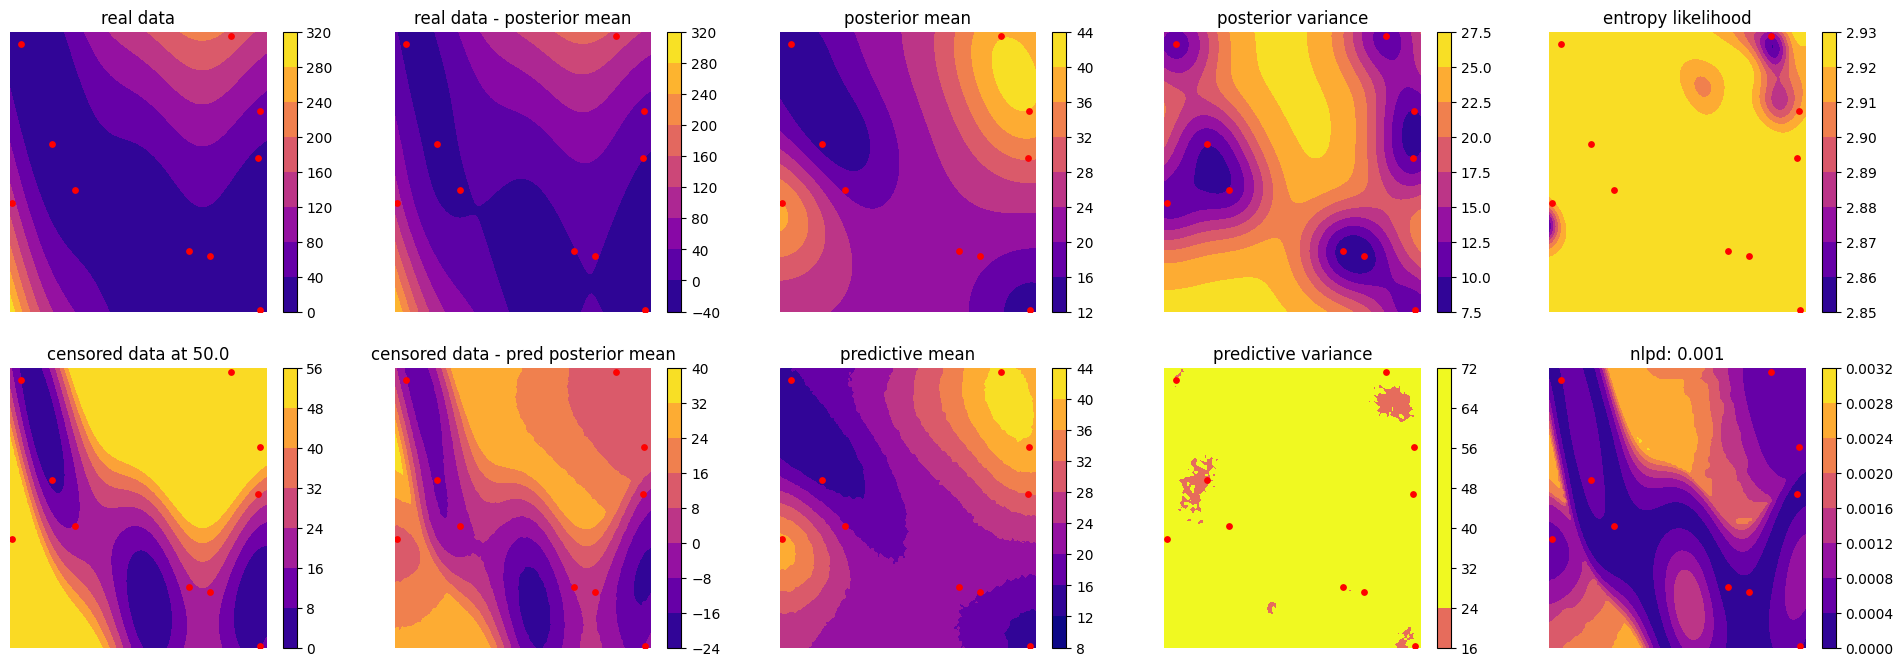

In [138]:
fig, ax = plt.subplots(2,5, figsize=(24, 8))
# plt.set_cmap(cmap='Purples_r')
# plt.set_cmap(cmap='PiYG')
plt.set_cmap(cmap='plasma')

cs = list(range(10))
#kwargs = dict(vmin=0, vmax=320)

zz = branin_hoo(xxyy).reshape(xx.shape)
#cs0 = ax[0,0].contourf(xx, yy, zz, **kwargs)
cs[0] = ax[0,0].contourf(xx, yy, zz,)
ax[0,0].scatter(x[:,0], x[:,1], s=60, marker='.', color='r')
ax[0,0].set_title('real data')
fig.colorbar(cs[0])
ax[0,0].axis('off')

zz = oracle(xxyy).reshape(xx.shape)
cs[1] = ax[1,0].contourf(xx, yy, zz)
ax[1,0].scatter(x[:,0], x[:,1], s=60, marker='.', color='r')
ax[1,0].set_title('censored data at %s'%(MAX_VALUE))
fig.colorbar(cs[1])
ax[1,0].axis('off')

zz = branin_hoo(xxyy).reshape(xx.shape) - f_mean.numpy(force=True).reshape(xx.shape)
cs[2] = ax[0,1].contourf(xx, yy, zz)
ax[0,1].scatter(x[:,0], x[:,1], s=60, marker='.', color='r')
ax[0,1].set_title('real data - posterior mean')
fig.colorbar(cs[2])
ax[0,1].axis('off')

zz = oracle(xxyy).reshape(xx.shape) - y_preds.sample_n(n=100).mean([0,1]).numpy(force=True).reshape(xx.shape)
cs[3] = ax[1,1].contourf(xx, yy, zz)
ax[1,1].scatter(x[:,0], x[:,1], s=60, marker='.', color='r')
ax[1,1].set_title('censored data - pred posterior mean')
fig.colorbar(cs[3])
ax[1,1].axis('off')

zz = f_mean.numpy(force=True).reshape(xx.shape)
cs[4] = ax[0,2].contourf(xx, yy, zz)
ax[0,2].scatter(x[:,0], x[:,1], s=60, marker='.', color='r')
ax[0,2].set_title('posterior mean')
fig.colorbar(cs[4])
ax[0,2].axis('off')

zz = f_var.numpy(force=True).reshape(xx.shape)
cs[5] = ax[0,3].contourf(xx, yy, zz)
ax[0,3].scatter(x[:,0], x[:,1], s=60, marker='.', color='r')
ax[0,3].set_title('posterior variance')
fig.colorbar(cs[5])
ax[0,3].axis('off')

final_nlpd = gpytorch.metrics.negative_log_predictive_density(likelihood(model(xxyy)), y_test_censored)#.numpy(force=True)
zz = final_nlpd.reshape([10,xx.shape[0],xx.shape[1]]).mean(0).numpy(force=True)
cs[6] = ax[1,4].contourf(xx, yy, zz)
ax[1,4].scatter(x[:,0], x[:,1], s=60, marker='.', color='r')
ax[1,4].set_title('nlpd: %.3f'%(final_nldp))
fig.colorbar(cs[6])
ax[1,4].axis('off')

zz = y_preds.sample_n(n=100).mean([0,1]).numpy(force=True).reshape(xx.shape)
cs[7] = ax[1,2].contourf(xx, yy, zz)
cmin, cmax = cs[4].get_clim()
cs[7].set_clim(cmin, cmax)
ax[1,2].scatter(x[:,0], x[:,1], s=60, marker='.', color='r')
ax[1,2].set_title('predictive mean')
fig.colorbar(cs[7])
ax[1,2].axis('off')

zz = y_preds.sample_n(n=100).var([0,1]).numpy(force=True).reshape(xx.shape)
cs[8] = ax[1,3].contourf(xx, yy, zz)
cmin1, cmax1 = cs[5].get_clim()
cs[8].set_clim(cmin1, cmax1)
ax[1,3].scatter(x[:,0], x[:,1], s=60, marker='.', color='r')
ax[1,3].set_title('predictive variance')
fig.colorbar(cs[8])
ax[1,3].axis('off')

zz = y_preds.entropy().mean(0).numpy(force=True).reshape(xx.shape)
cs[9] = ax[0,4].contourf(xx, yy, zz)
ax[0,4].scatter(x[:,0], x[:,1], s=60, marker='.', color='r')
ax[0,4].set_title('entropy likelihood')
fig.colorbar(cs[9])
ax[0,4].axis('off')
